In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
sz = 128

path = Path('data')
path_img = path/f'train-{sz}'

In [3]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('data/train-128/mushroom_45567.png'),
 PosixPath('data/train-128/boomerang_61163.png'),
 PosixPath('data/train-128/pants_68293.png'),
 PosixPath('data/train-128/candle_83850.png'),
 PosixPath('data/train-128/scorpion_122953.png')]

In [4]:
pat = r'/([^/]+)_\d+.png$'

In [5]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=128, test=Path('../test-128'))
data.normalize(imagenet_stats)

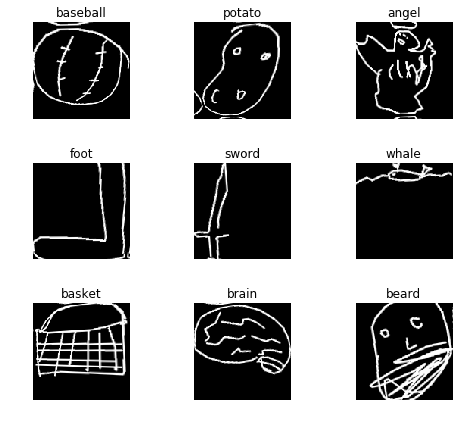

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)
len(data.classes),data.c

['mushroom', 'boomerang', 'pants', 'candle', 'scorpion', 'pineapple', 't-shirt', 'marker', 'hedgehog', 'oven', 'The_Great_Wall_of_China', 'crocodile', 'fence', 'soccer_ball', 'sheep', 'camel', 'onion', 'firetruck', 'campfire', 'motorbike', 'cow', 'microphone', 'mermaid', 'helicopter', 'line', 'umbrella', 'donut', 'finger', 'lightning', 'jail', 'hurricane', 'airplane', 'drill', 'stop_sign', 'carrot', 'blueberry', 'tent', 'clarinet', 'keyboard', 'lighthouse', 'streetlight', 'van', 'backpack', 'floor_lamp', 'kangaroo', 'screwdriver', 'tornado', 'whale', 'hot_dog', 'beard', 'pliers', 'jacket', 'parrot', 'bread', 'cannon', 'goatee', 'penguin', 'television', 'flamingo', 'foot', 'fan', 'bowtie', 'snake', 'asparagus', 'paintbrush', 'mailbox', 'fire_hydrant', 'knee', 'animal_migration', 'map', 'bathtub', 'peanut', 'rollerskates', 'saw', 'dragon', 'cat', 'hamburger', 'key', 'mountain', 'hockey_puck', 'barn', 'washing_machine', 'squiggle', 'teapot', 'telephone', 'cake', 'light_bulb', 'fish', 'cal

(340, 340)

## Training: resnet34

In [6]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(4)

Total time: 21:07
epoch  train loss  valid loss  error_rate
1      1.845311    1.377450    0.373452    (05:13)
2      1.641016    1.170062    0.321792    (05:17)
3      1.438249    1.041284    0.288952    (05:18)
4      1.370582    0.994077    0.277115    (05:18)



In [10]:
learn.save('stage-1')

## Results

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

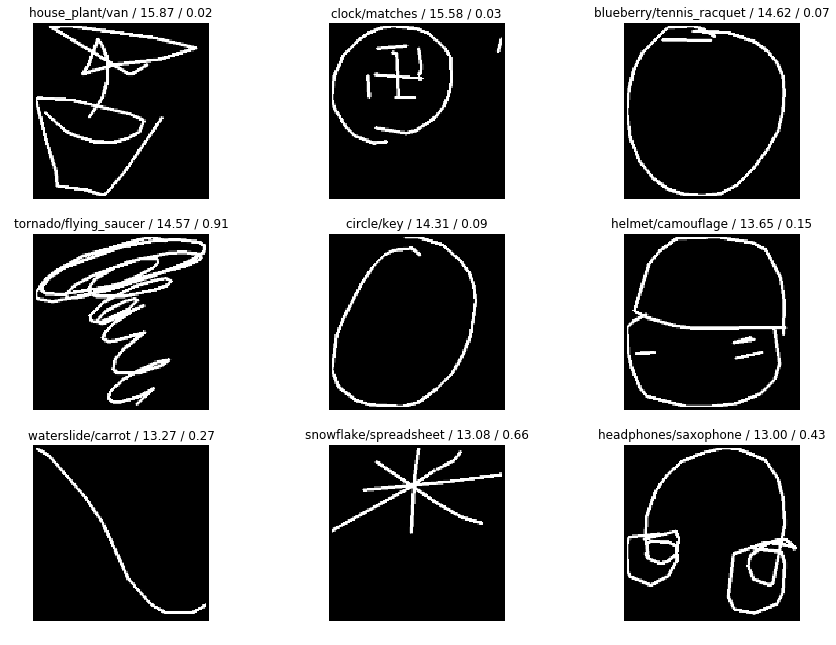

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

## Unfreezing, fine-tuning, and learning rates

In [7]:
learn.load('stage-1')

In [8]:
learn.unfreeze()

In [9]:
learn.lr_find()

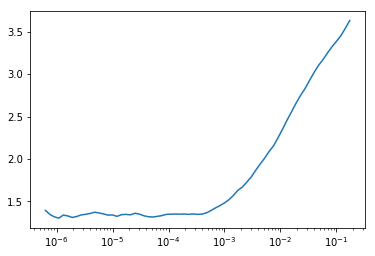

In [10]:
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(2, max_lr=slice(5e-6,5e-4))

Total time: 14:13
epoch  train loss  valid loss  error_rate
1      1.222878    0.918883    0.261188    (07:05)
2      1.085056    0.808821    0.232724    (07:07)



In [12]:
learn.save('stage-2')

## Generate submission

In [7]:
learn.load('stage-2')

In [8]:
preds = learn.TTA(is_test=True)[0]

Total time: 07:19



In [36]:
top_3 = np.argsort(preds.numpy())[:, ::-1][:, :3]

In [37]:
n, _ = top_3.shape
labels = []
for i in range(n):
    labels.append(' '.join([learn.data.train_ds.ds.classes[idx] for idx in top_3[i]]))

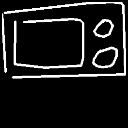

In [38]:
learn.data.test_dl.dl.dataset[0][0]

In [39]:
labels[0]

'microwave oven picture_frame'

In [40]:
key_ids = [path.stem for path in learn.data.test_dl.dl.dataset.x]

In [41]:
os.makedirs(f'subs', exist_ok=True)

In [42]:
sub = pd.DataFrame({'key_id': key_ids, 'word': labels})

In [43]:
sub.head()

,key_id,word
0,9245637663537661,microwave oven picture_frame
1,9548313540512274,rhinoceros raccoon frog
2,9327384663362339,hamburger basket cooler
3,9128872627878490,marker pencil crayon
4,9241865586170401,peas string_bean clarinet


In [44]:
name = 'first_sub'

In [45]:
sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [46]:
pd.read_csv(f'subs/{name}.csv.gz').head()

,key_id,word
0,9245637663537661,microwave oven picture_frame
1,9548313540512274,rhinoceros raccoon frog
2,9327384663362339,hamburger basket cooler
3,9128872627878490,marker pencil crayon
4,9241865586170401,peas string_bean clarinet


In [47]:
# !kaggle competitions submit -c quickdraw-doodle-recognition -f subs/{name}.csv.gz -m "{name}"

Successfully submitted to Quick, Draw! Doodle Recognition Challenge